## Advance Lane Lines

In [1]:
# Importing packages
import cv2
import glob
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Camera calibration

In [2]:
images = glob.glob('camera_cal/calibration*.jpg')
fig = plt.figure(figsize=(50,150))

def get_camera_calibration(show_img=False):
    """
    Calibrates the camera based on the calibration chessboard images
    provided
    """
    nx, ny = 9, 6
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            if show_img:
                fig.add_subplot(math.ceil(len(images) / 2), 2, idx)
                cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
                plt.imshow(img)
    return cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)

ret, mtx, dist, rvecs, tvecs = get_camera_calibration()

### Distortion correction

In [3]:
def undistort_img(img):
    """
    Takes an image and undistorts it based on the calibration constansts
    Input: Distorted image
    Output: Undistorted image
    """
    return cv2.undistort(img, mtx, dist, None, mtx)

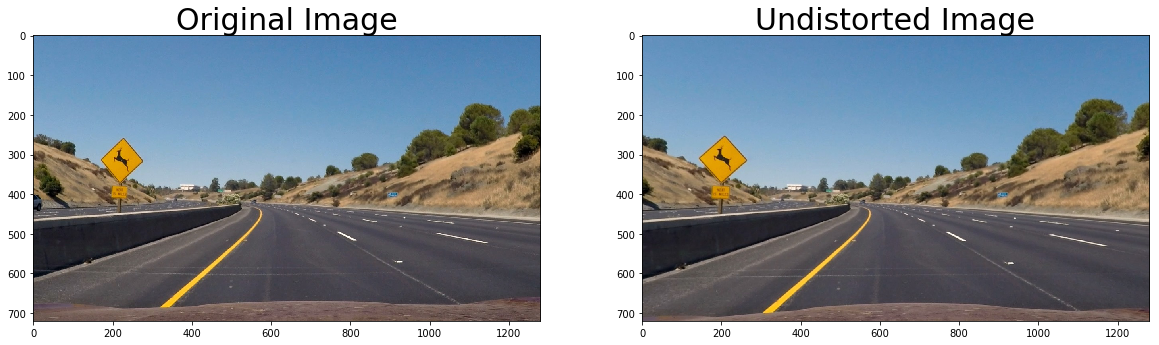

In [4]:
# Test undistortion of test image
test_img = plt.imread('test_images/test2.jpg')
undistorted_img = undistort_img(test_img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize=30)

### Color/gradient threshold

#### Define Util functions for thresholding

In [5]:
# Define utility functions for applying thresholding and transform of images

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel = cv2.Sobel(gray, cv2.CV_64F, int(orient == 'x'), int(orient == 'y'))
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = (sobelx**2 + sobely**2)**0.5
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > mag_thresh[0]) & (scaled_sobel < mag_thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobely = np.absolute(sobely)
    grad = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(grad)
    dir_binary[(grad > thresh[0]) & (grad < thresh[1])] = 1
    return dir_binary

In [6]:
# Choose a Sobel kernel size
ksize = 3

In [7]:
def img_processing_pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    """
    Takes in an image and processes it to apply filtering based on channels
    Input: Image to be thresholdedm and threshold values
    Output: Stacked thresold and combined binary threshold
    """
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hsv[:,:,0]
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Threshold hue channel
    yellow_mask = cv2.inRange(hsv, np.array([20, 100, 100]), np.array([30, 255, 255]))
    y_channel = cv2.bitwise_and(hsv, hsv, mask = yellow_mask)
    y_channel = y_channel[:,:,2]

    h_binary = np.zeros_like(h_channel)
    # y_thresh = (15, 100)
    # h_binary[(h_channel >= y_thresh[0]) & (h_channel <= y_thresh[1])] = 1

    combined = np.zeros_like(sxbinary)
    combined[(sxbinary == 1) | (s_binary == 1)] = 1
    return np.dstack((h_binary, sxbinary, s_binary)), combined


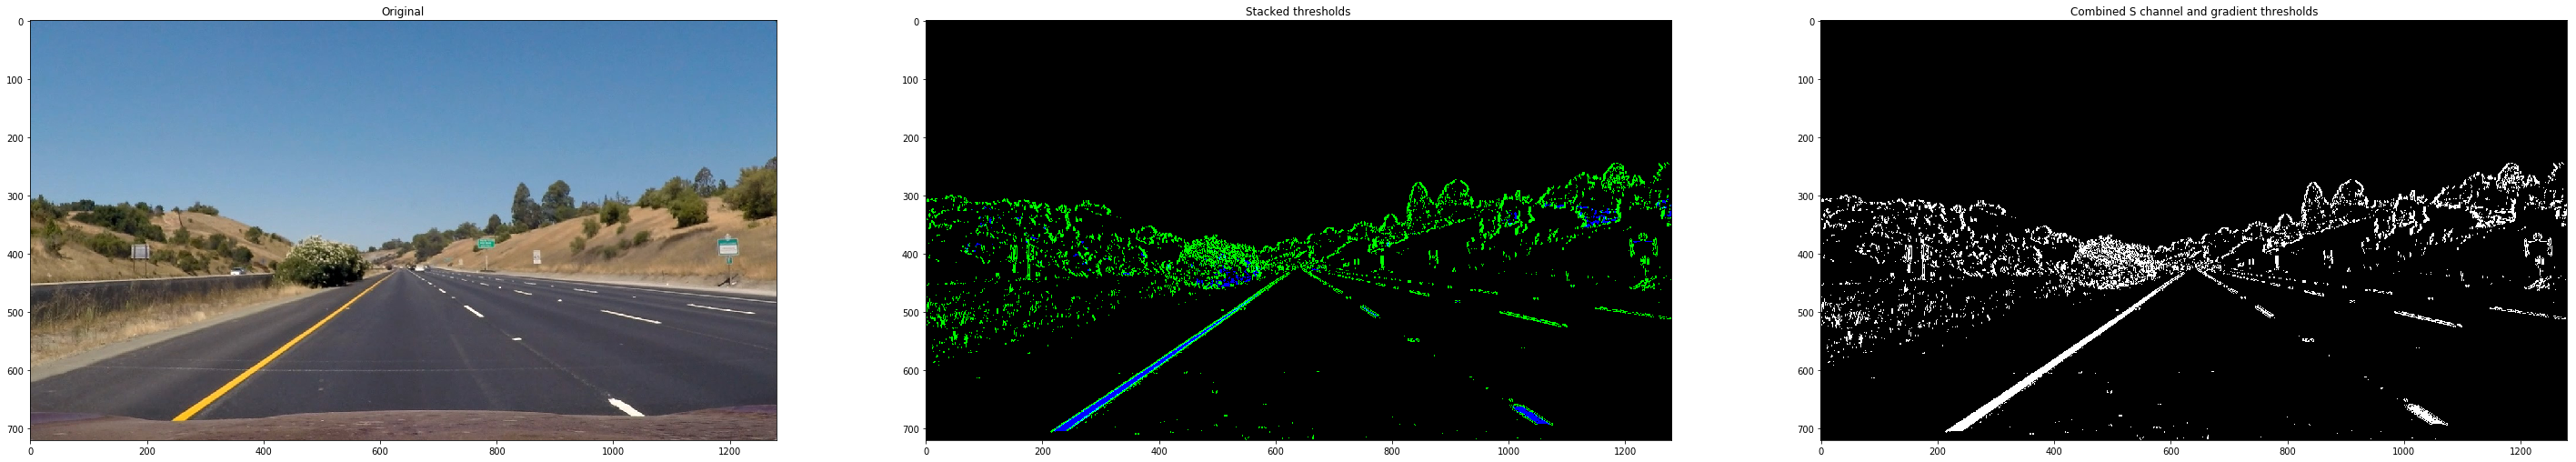

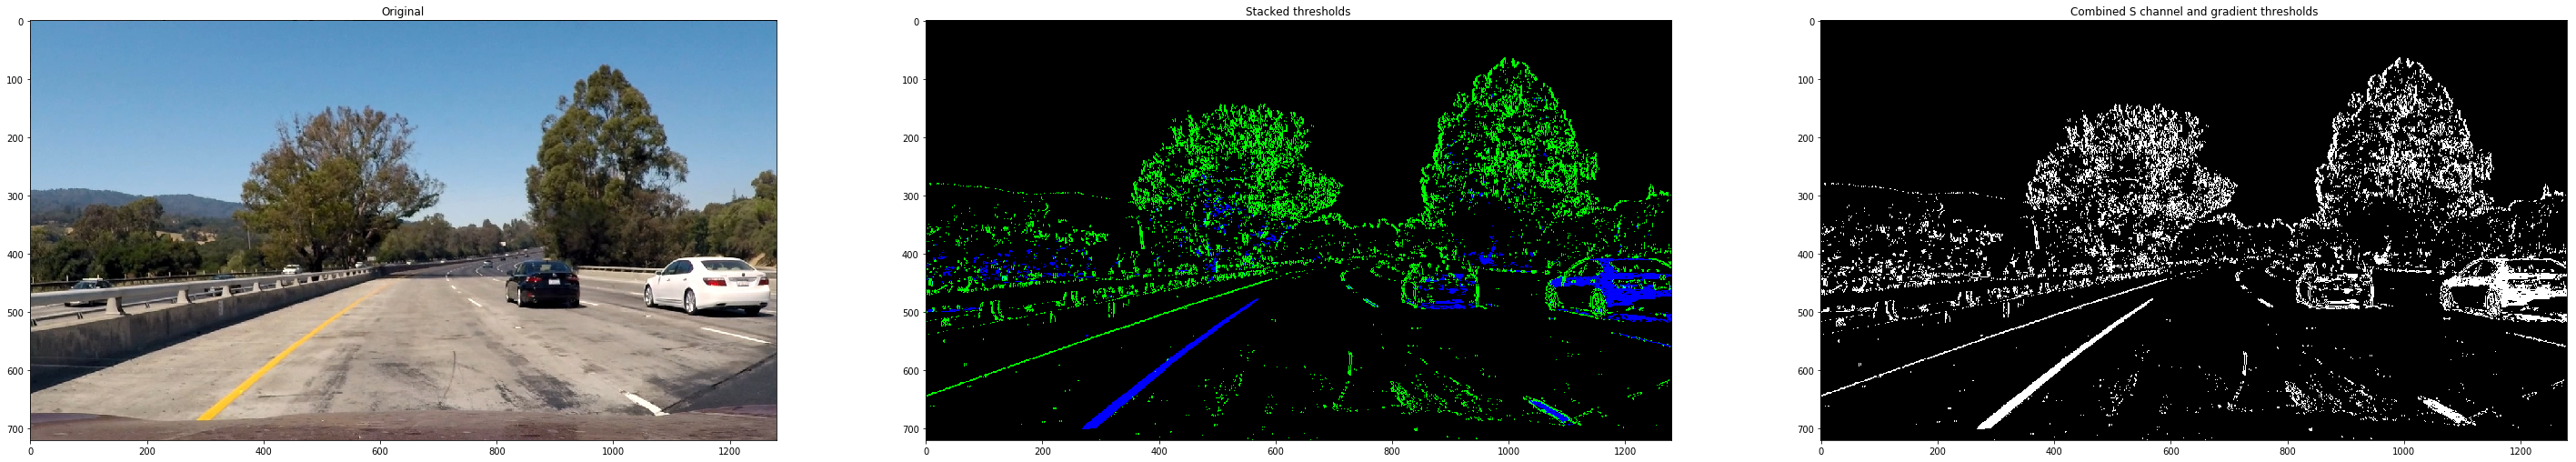

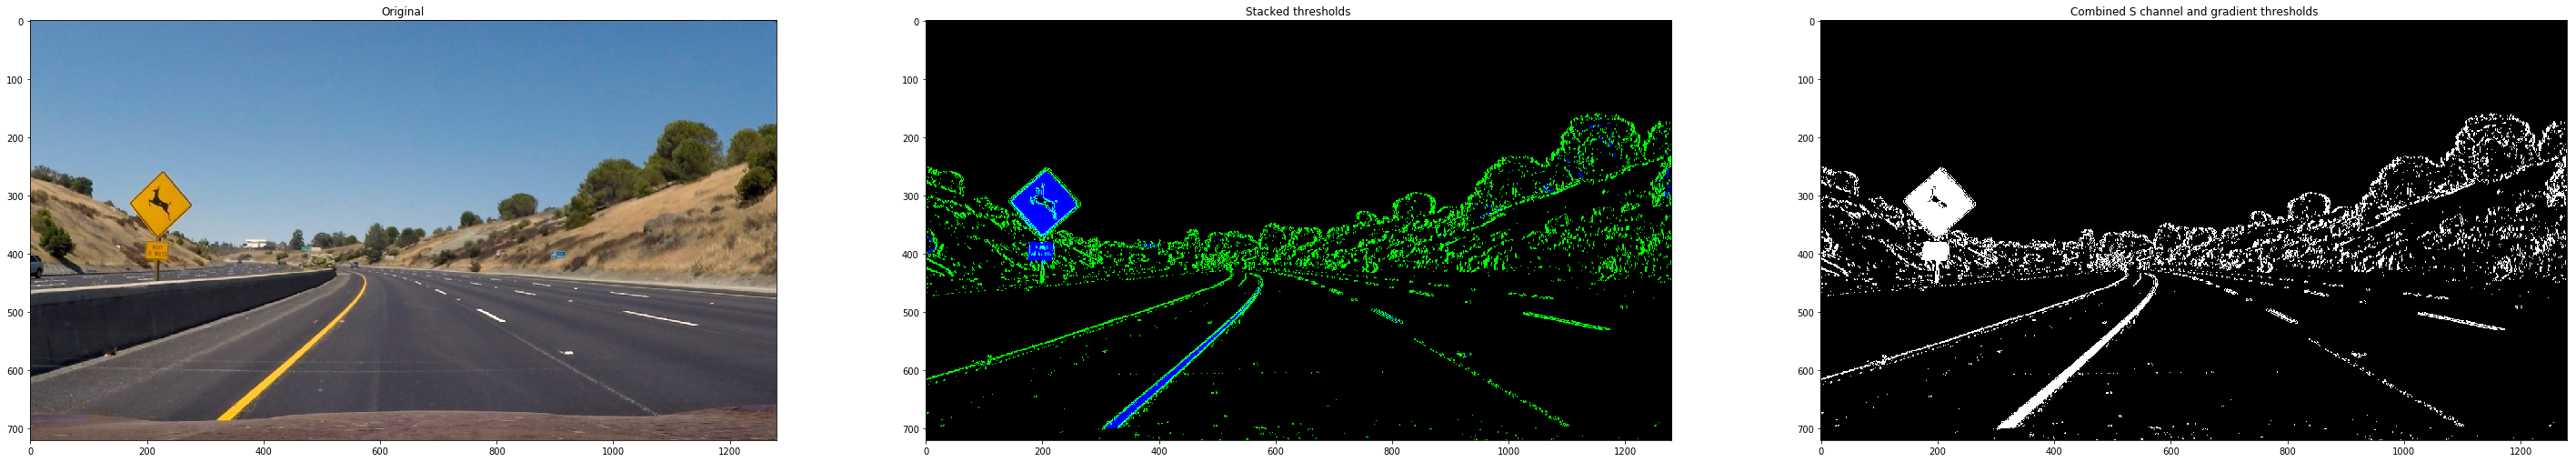

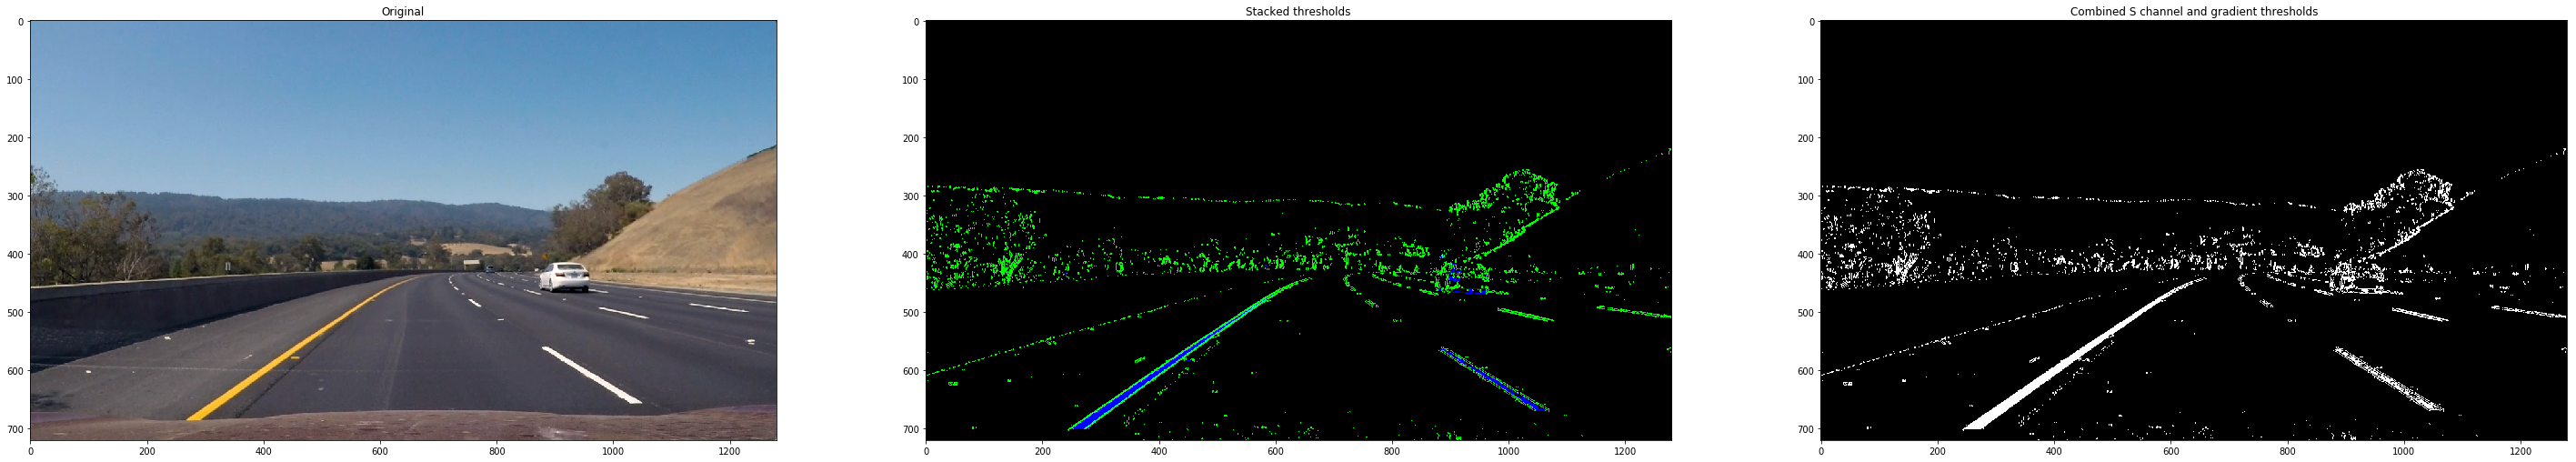

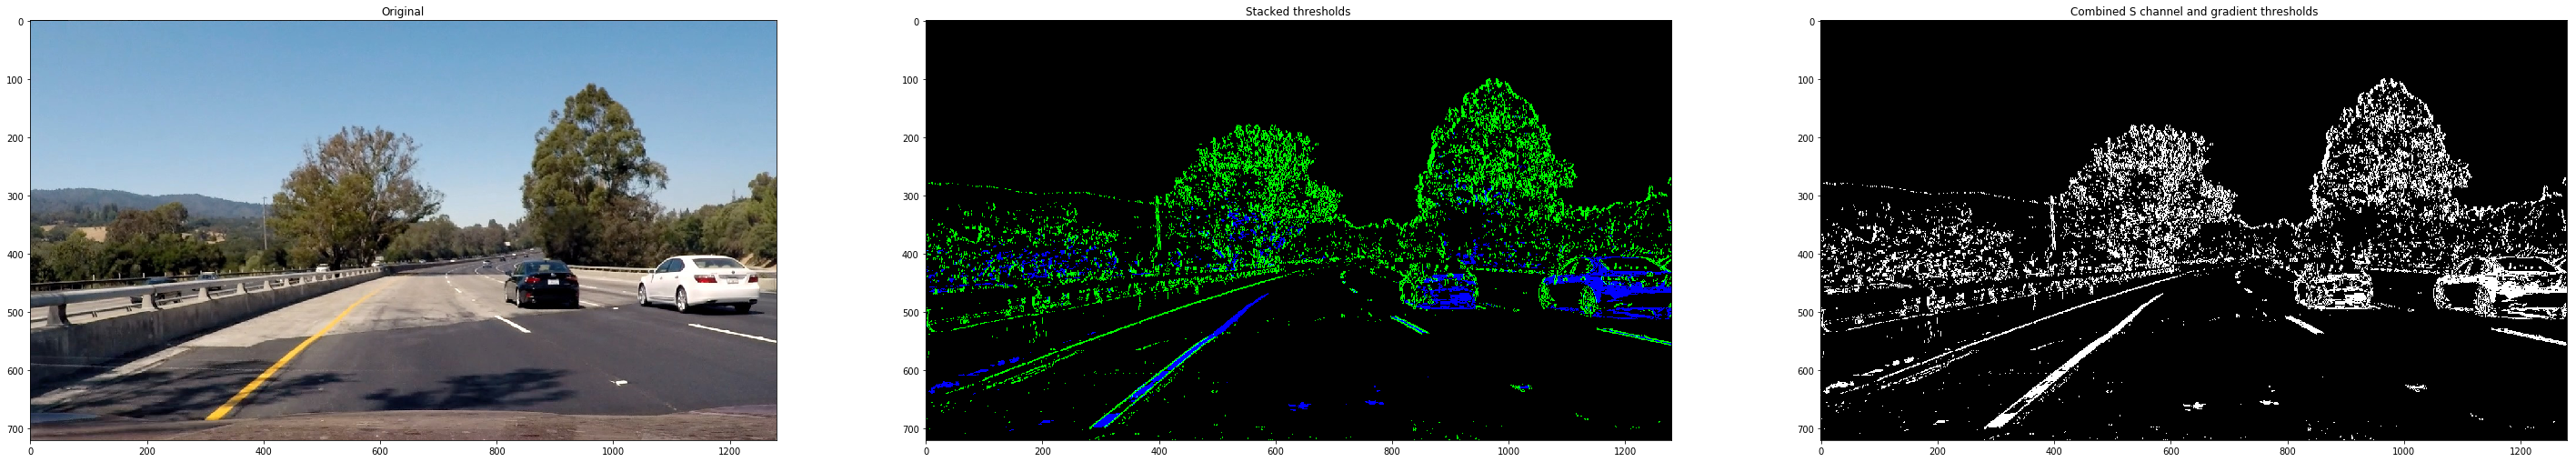

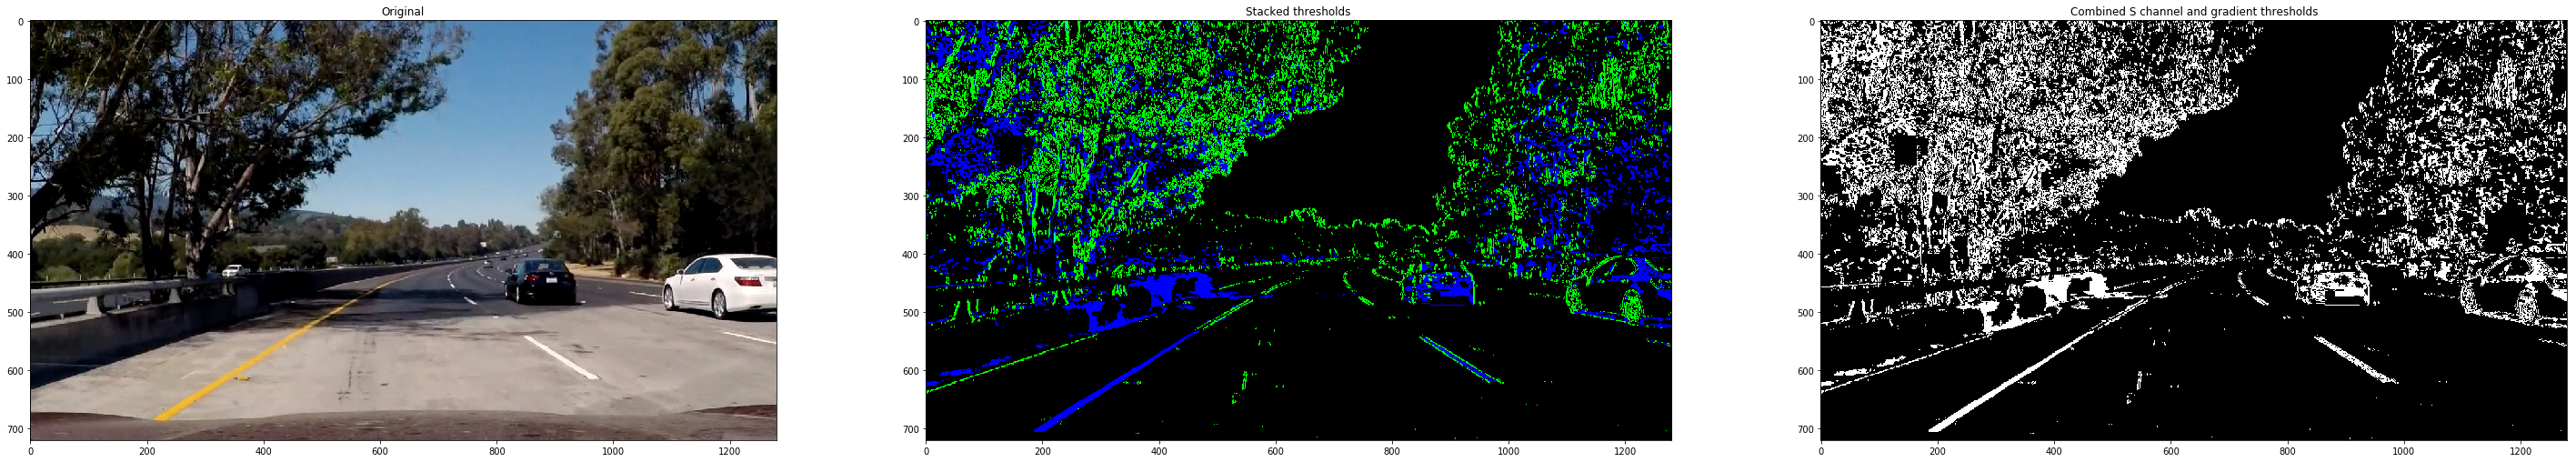

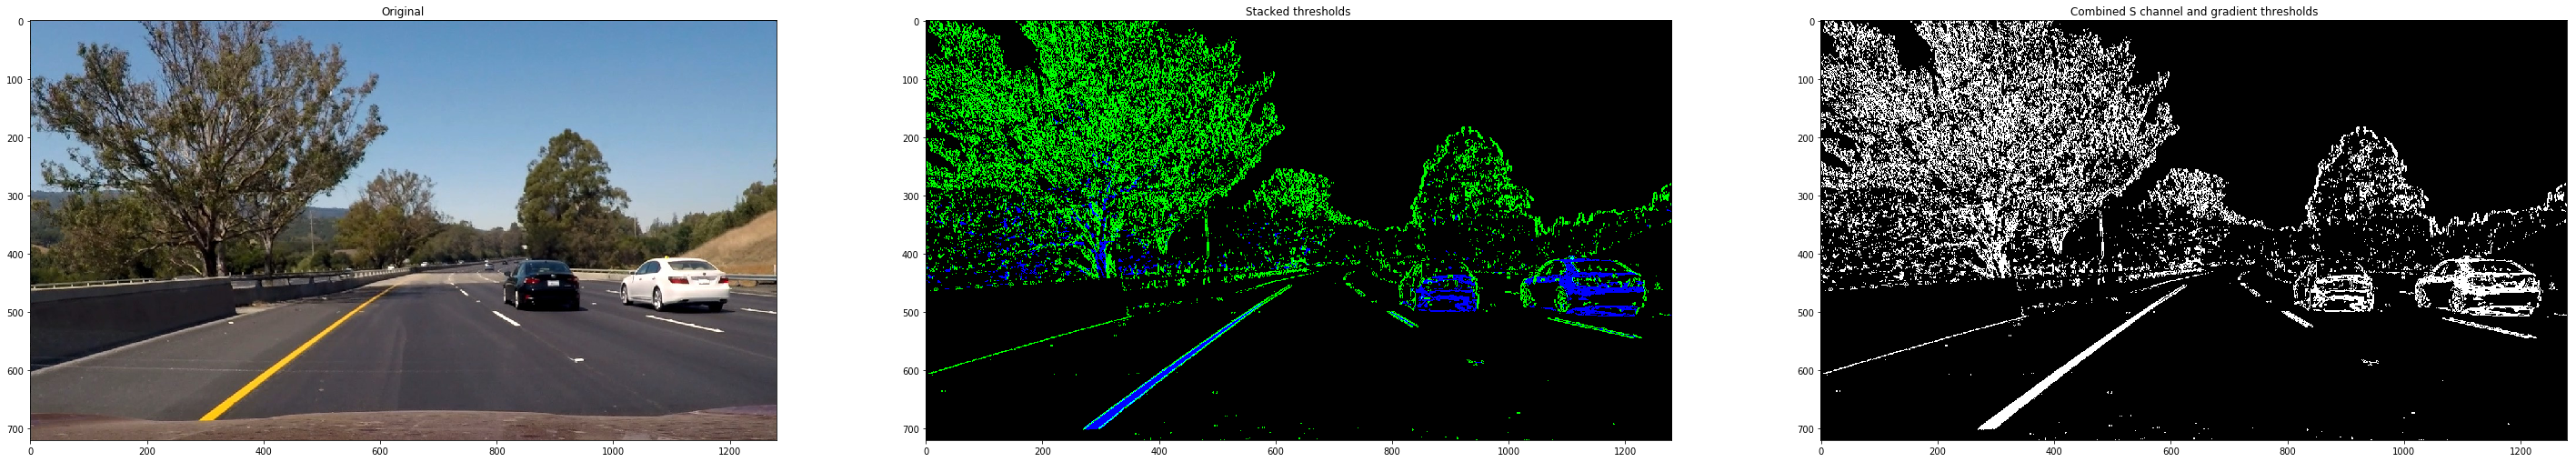

In [8]:
# Apply image processing pipeline to the test images

test_files = glob.glob('./test_images/*.jpg')
for file in test_files:
    test_img = plt.imread(file)
    color_binary, combined_binary = img_processing_pipeline(undistort_img(test_img))
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(50,50))
    ax1.set_title('Original')
    ax1.imshow(test_img)
    ax2.set_title('Stacked thresholds')
    ax2.imshow(color_binary)
    ax3.set_title('Combined S channel and gradient thresholds')
    ax3.imshow(combined_binary, cmap='gray')

### Perspective transform

In [9]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [10]:
def perspective_transform(img):
    """
    Applies a perspective transform on an image by calculating M and Minv matrices
    Input: Image
    Output: Perspective transformed region of interest of the image
    """
    global M
    global Minv
    img_size = (img.shape[1], img.shape[0])
    
    # Four source co-ordinates
    src = np.float32(
        [[ 560., 460.],
         [ 720., 460.],
         [1140., 680.],
         [ 140., 680.]])
    offset = 100. # offset for dst points
    dst = np.float32(
        [[offset, 0],
         [img_size[0]-offset, 0],
         [img_size[0]-offset, img_size[1]],
         [offset, img_size[1]]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

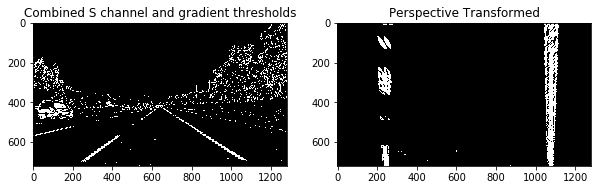

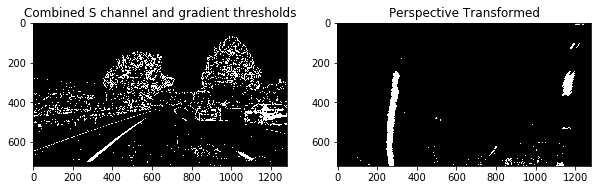

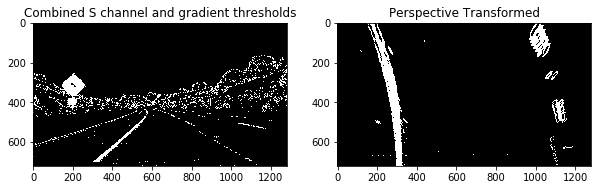

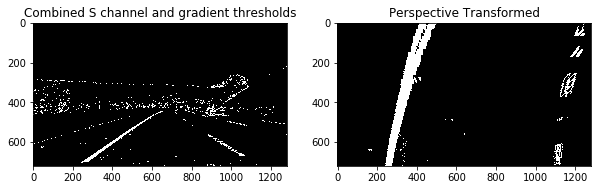

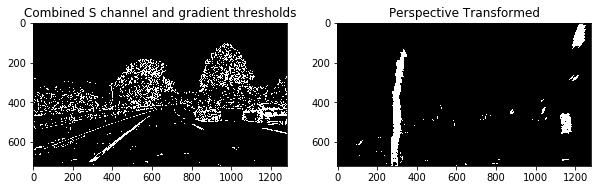

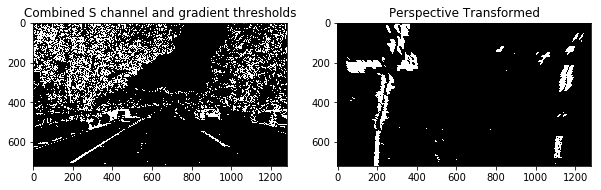

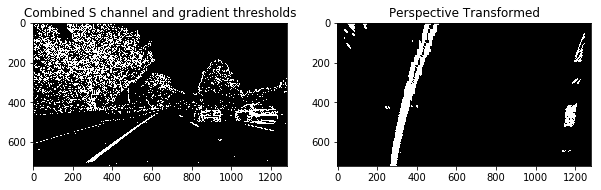

In [11]:
# Test the perspective transform of ROI in test images

warped_imgs = []
for file in test_files:
    test_img = plt.imread(file)
    _, combined_binary = img_processing_pipeline(undistort_img(test_img))
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
    ax1.set_title('Combined S channel and gradient thresholds')
    ax1.imshow(combined_binary, cmap='gray')

    warped_img = perspective_transform(combined_binary)
    ax2.set_title('Perspective Transformed')
    ax2.imshow(warped_img, cmap='gray')
    warped_imgs.append(warped_img)

### Detect lane lines

#### Apply the sliding window approach discussed in the project lesson

In [12]:
def sliding_window(binary_warped, left_fit=None, right_fit=None, visualize=False):
    """
    Applies a sliding window strategy to identify lane lines and fit a 2nd degree polynomial
    Input: Image to detect, left and right fit values for previous frame if available
    Output: Fitted values from lane detection
    """
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Set the width of the windows +/- margin
    margin = 100
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    if left_fit is None or right_fit is None:
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & \
                              (nonzeroy < win_y_high) & \
                              (nonzerox >= win_xleft_low) & \
                              (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & \
                               (nonzeroy < win_y_high) & \
                               (nonzerox >= win_xright_low) & \
                               (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    else:
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + \
                                       left_fit[1]*nonzeroy + \
                                       left_fit[2] - margin)) & \
                          (nonzerox < (left_fit[0]*(nonzeroy**2) + \
                                       left_fit[1]*nonzeroy + \
                                       left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + \
                                        right_fit[1]*nonzeroy + \
                                        right_fit[2] - margin)) & \
                           (nonzerox < (right_fit[0]*(nonzeroy**2) + \
                                        right_fit[1]*nonzeroy + \
                                        right_fit[2] + margin)))  


    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    if visualize:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        
        fig = plt.figure(figsize=(10, 10))
        fig.add_subplot(2, 2, 1)
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
    return left_fitx, right_fitx, left_fit, right_fit

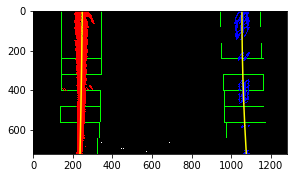

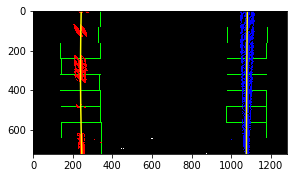

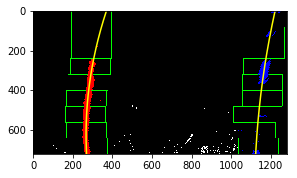

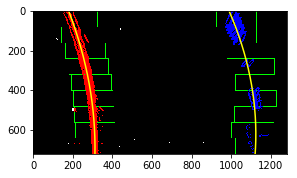

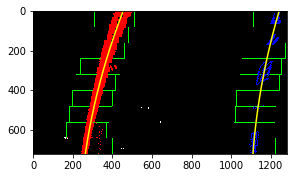

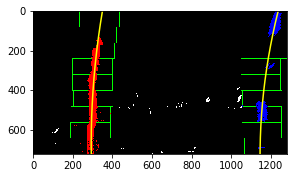

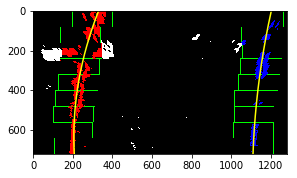

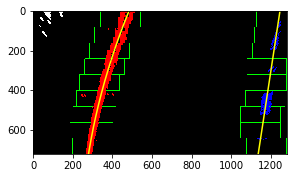

In [13]:
# left_fitx, right_fitx, left_fit, right_fit = sliding_window(warped_img, left_fit, right_fit, True)
for warped_img in warped_imgs:
    left_fitx, right_fitx, left_fit, right_fit = sliding_window(warped_img, None, None, True)

### Determine the lane curvature

In [14]:
# Define meters/pixel constants

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

In [15]:
def get_curvature(ploty, leftx, rightx):
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix +\
                           left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix +\
                            right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')

In [16]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, n=5):
        self.n = n
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
    
    def set_recent_xfitted(self):
        if len(self.recent_xfitted) == self.n:
            self.recent_xfitted.pop(0)
        self.recent_xfitted.append(self.allx)
    
    def set_bestx(self):
        avg = 0
        for fit in self.recent_xfitted:
            avg += np.array(fit)
        self.bestx = avg / len(self.recent_xfitted)

    def set_line_base_pos(self):
        y_max = max(self.ally)
        x_max = self.current_fit[0] * y_max**2 \
                + self.current_fit[1] * y_max \
                + self.current_fit[2]
        mid = 640 # Assume mid position to be 1280 / 2 = 640px
        self.line_base_pos = (x_max - 640) * ym_per_pix

    def set_radius_of_curvature(self):
        y_eval = np.max(self.ally)
        # Fit new polynomials to x,y in world space
        fit_cr = np.polyfit(self.ally*ym_per_pix, self.allx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        self.radius_of_curvature = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix \
                                          + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])

    def update_current(self, fitx, current_fit, ploty):
        self.allx = fitx
        self.ally = ploty
        self.current_fit = current_fit
        self.set_radius_of_curvature()
        self.set_line_base_pos()

    def accept(self):
        self.detected = True
        self.set_recent_xfitted()
        self.set_bestx()


In [17]:
def project_lane(image, warped, ploty, left_fitx, right_fitx, visualize=False):
    """
    Project unwarped region of interest back to provided image
    Input: Image, warped ROI, left and right line coordinates
    Output: unwarped image projected back on the provided test image
    """
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    if visualize:
        plt.imshow(result)
    return result

In [18]:
MAX_ALLOWED_ROC_DIFF = 6 # in meters
MAX_ALLOWED_DIST_DIFF = 37
MIN_ALLOWED_DIST_DIFF = 33
MAX_FAILED_FRAMES_ALLOWED = 24

def sanity_check(left_lane, right_lane):
    """
    Does a sanity check to find if detected lanes are valid or not
    Input: Left and Right detected lanes
    Output: Lanes are valid or not
    """
    # If no recent data assume correct
    if len(left_lane.recent_xfitted) == 0 or len(right_lane.recent_xfitted) == 0:
        return True
    # Checking that they have similar curvature
    # if abs(left_lane.radius_of_curvature - right_lane.radius_of_curvature) < MAX_ALLOWED_ROC_DIFF:
    #    return True
    # Checking that they are separated by approximately the right distance horizontally
    if MIN_ALLOWED_DIST_DIFF < (right.line_base_pos - left.line_base_pos) < MAX_ALLOWED_DIST_DIFF:
        return True
    return False
    

In [19]:
def add_radius_of_curvature(image, left_roc, right_roc):
    """
    Adds additional text to processed image
    Input: Image and values to be added
    Output: Image with text overlayed
    """
    font = cv2.FONT_HERSHEY_SIMPLEX
    left_roc_str = str('Left Curvature: '+ str(np.round(left_roc/1000., 3)) +'km')
    cv2.putText(image, left_roc_str, (50,50), font, 1, (255,255,255), 2, cv2.LINE_AA)
    right_roc_str = str('Right Curvature: '+ str(np.round(right_roc/1000., 3)) +'km')
    cv2.putText(image, right_roc_str, (50,100), font, 1, (255,255,255), 2, cv2.LINE_AA)
    return image

### Define a pipeline to process images and identify lanes

In [20]:
def pipeline(image):
    """
    Processes an image to undistort, warp ROI, identify lane lines and project them back to the
    image with additional information
    Input: Image to be processed
    Output: Processed image
    """
    global left
    global right
    ## Undistort and process the image to get the binary
    undistorted_img = undistort_img(image)
    _, combined_binary = img_processing_pipeline(undistorted_img)
    ## Apply a perspective transform on the image
    binary_warped = perspective_transform(combined_binary)
    #plot y values
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    ## Identify left and right lanes and update the corresponding line instances
    if left.detected and right.detected:
        left_fitx, right_fitx, left_fit, right_fit = \
                    sliding_window(binary_warped, left.current_fit, right.current_fit)
    else:
        left_fitx, right_fitx, left_fit, right_fit = sliding_window(binary_warped)
    
    # Update current values in the line class
    left.update_current(left_fitx, left_fit, ploty)
    right.update_current(right_fitx, right_fit, ploty)
    # Do a sanity check to verify if the line should be accepted or not
    if sanity_check(left, right):
        left.accept()
        right.accept()
    else:
        left.detected = False
        right.detected = False
    ## Project lane lines back onto the image and return result
    result = project_lane(undistorted_img, binary_warped, ploty, left.bestx, right.bestx)
    return add_radius_of_curvature(result, left.radius_of_curvature, right.radius_of_curvature)
    

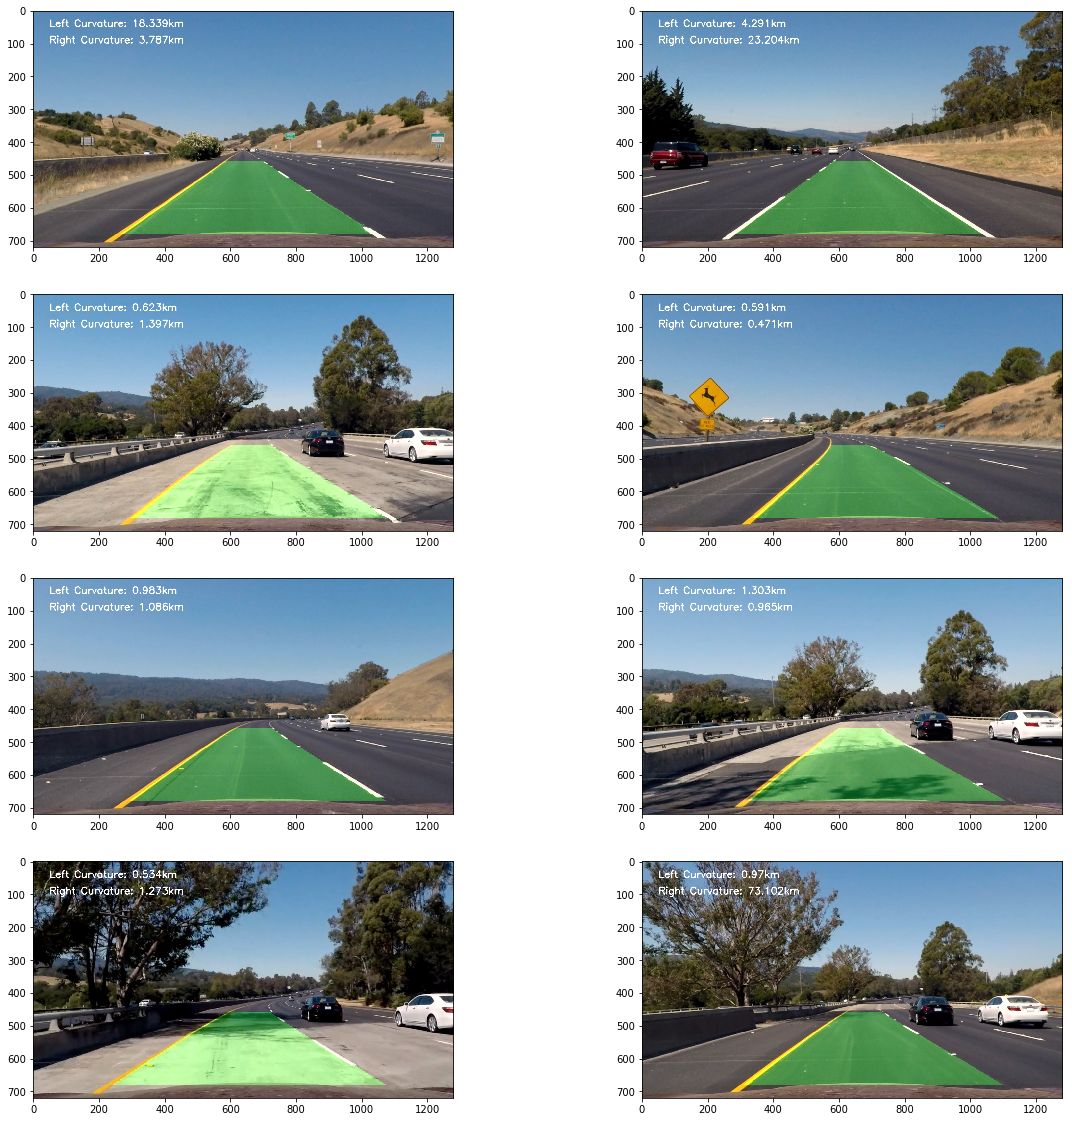

In [21]:
# Test pipeline

test_files = glob.glob('./test_images/*.jpg')
fig = plt.figure(figsize=(20, 20))
idx = 1
for file in test_files:
    ## Get instances for a left and right lane lines
    left = Line()
    right = Line()
    img = plt.imread(file)
    result = pipeline(img)
    fig.add_subplot(4, 2, idx)
    plt.imshow(result)
    idx += 1

In [22]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [23]:
def process_image(image):
    return pipeline(image)

In [24]:
## Get instances for a left and right lane lines
left = Line()
right = Line()

output1 = 'video_output/project_video.mp4'
clip1 = VideoFileClip('project_video.mp4')
project_video = clip1.fl_image(process_image)
%time project_video.write_videofile(output1, audio=False)

[MoviePy] >>>> Building video video_output/project_video.mp4
[MoviePy] Writing video video_output/project_video.mp4


100%|█████████▉| 1260/1261 [04:19<00:00,  5.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_output/project_video.mp4 

CPU times: user 3min 36s, sys: 1min 16s, total: 4min 52s
Wall time: 4min 21s


In [25]:
## Get instances for a left and right lane lines
left = Line()
right = Line()

output2 = 'video_output/challenge_video.mp4'
clip2 = VideoFileClip('challenge_video.mp4')
challenge_video = clip2.fl_image(process_image)
%time challenge_video.write_videofile(output2, audio=False)

[MoviePy] >>>> Building video video_output/challenge_video.mp4
[MoviePy] Writing video video_output/challenge_video.mp4


100%|██████████| 485/485 [01:29<00:00,  5.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_output/challenge_video.mp4 

CPU times: user 1min 19s, sys: 25.9 s, total: 1min 45s
Wall time: 1min 30s


In [26]:
## Get instances for a left and right lane lines
left = Line()
right = Line()

output3 = 'video_output/harder_challenge_video.mp4'
clip3 = VideoFileClip('harder_challenge_video.mp4')
harder_challenge_video = clip3.fl_image(process_image)
%time harder_challenge_video.write_videofile(output3, audio=False)

[MoviePy] >>>> Building video video_output/harder_challenge_video.mp4
[MoviePy] Writing video video_output/harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [04:24<00:00,  5.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_output/harder_challenge_video.mp4 

CPU times: user 3min 40s, sys: 1min 9s, total: 4min 50s
Wall time: 4min 25s
